In [1]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
def sigma_ellipse(p, cov, n): 
    eig_vals, eig_vec = np.linalg.eig(cov)
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [3]:
class KalmanFilter: ###kf4init
    def __init__(self, envmap, init_pose, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        self.belief = multivariate_normal(mean=init_pose, \
                                        cov=np.diag([1e-10, 1e-10, 1e-10])) 
        self.motion_noise_stds = motion_noise_stds
        self.map = envmap  #以下3行追加（Mclと同じ）
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
    def observation_update(self, observation):  #追加
        # 計測更新ステップ
        # 観測後の信念の更新
        # 計測されたランドマークごとにfor文をまわし，self.beliefに反映
        for d in observation:
            # H, Q, Kを計算していき,最後に信念分布の中心と共分散行列の更新をする．
            z = d[0]
            obs_id = d[1]
            
            ###Hの計算###
            # Hは，μ̂まわりでhをxで偏微分したもの
            # 単位を合わせるための行列
            # 実習 確率ロボティクス 式(6.26)
            mx, my = self.map.landmarks[obs_id].pos
            mux, muy, mut = self.belief.mean
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])
            
            ###Qの計算###
            # Qは雑音の共分散行列
            # 実習 確率ロボティクス 式(6.30)
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos)
            distance_dev = self.distance_dev_rate*hmu[0]
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2]))
            
            ###カルマンゲインの計算###
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            ###更新###
            # ラウンドマークの計測値を信念に反映した後の分布の中心の計算
            # 1ステップ前の信念から計算
            # 実習 確率ロボティクス 式(6.39)
            self.belief.mean += K.dot(z - hmu)
            # 信念の共分散の計算
            # 実習 確率ロボティクス 式(6.40)
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
        
    def motion_update(self, nu, omega, time): #追加
        # 予測ステップ
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
        if abs(nu) < 1e-5:         nu = 1e-5

        ###Mtの計算###
        # 状態遷移確率の線形化を行っている．
        # 速度・角速度の分布
        # 実習 確率ロボティクス 式(6.4)
        v = self.motion_noise_stds
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
        
        ###At-1の計算###
        # 状態遷移確率の線形化の続き
        # 速度・角速度から状態空間へ
        # 実習 確率ロボティクス 式(6.10)
        t = self.belief.mean[2]
        st, ct = math.sin(t), math.cos(t)
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time)
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        
        ###Fの計算###
        # 信念分布の遷移
        # 実習 確率ロボティクス 式(6.16)
        F = np.diag([1.0, 1.0, 1.0])
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
            
        ###ロボットが移動後の信念の共分散行列（self.belief.cov）と信念の中心（self.belief.mean）の計算###
        # 信念の共分散行列の計算
        # 実習 確率ロボティクス 式(6.18)
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)
        # 信念の中心を計算
        # 実習 確率ロボティクス 式(6.19)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)
        
    def draw(self, ax, elems):
        # 信念の可視化
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
class KfAgent(Agent): 
    def __init__(self, time_interval, nu, omega, kf):
        super().__init__(nu, omega)
        self.kf = kf
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):  ###kfagent4
        # 予測ステップ
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) 
        self.prev_nu, self.prev_omega = self.nu, self.omega
        # 計測更新ステップ
        self.kf.observation_update(observation)   #追加
        return self.nu, self.omega
        
    def draw(self, ax, elems): #追加
        # 信念の可視化
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


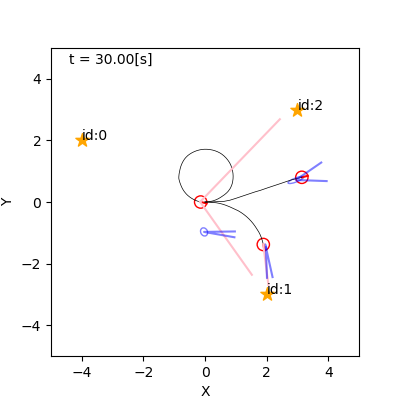

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    # ロボットの初期位置
    initial_pose = np.array([0, 0, 0]).T
    # 1台目（旋回する）
    kf = KalmanFilter(m, initial_pose)
    # カルマンフィルタを実行し，時刻tの信念（belief）を平均値と共分散行列で表現
    # 信念の可視化も行う．
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, kf)
    # ロボットに反映
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    
    # 1台目にやった同じ方法で，移動する方向のみを変えて残り2台実行する．
    
    # 2台目（右にまっすぐ）
    kf = KalmanFilter(m, initial_pose)
    linear = KfAgent(time_interval, 0.1, 0.0, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=linear, color="red")
    world.append(r)
    
    # 3台目（右旋回）
    kf = KalmanFilter(m, initial_pose)
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=right, color="red")
    world.append(r)

    world.draw()